
# 3.4 AGB modeling and mapping at the tile scale
To run this notebook, make sure to select 'r-with-gdal' as the kernel (bottom left corner of browser window).


In [106]:
#----------------------------------------------#
# Installing packages
#----------------------------------------------#3
#install.packages("randomForest")
#install.packages("raster")
#install.packages("data.table")
#install.packages('quantregForest')


#----------------------------------------------#
# loading packages and functions
#----------------------------------------------#
library(randomForest)
library(quantregForest)
library(raster)
library(rgdal)
library(data.table)
library(ggplot2)
source("/projects/icesat2_boreal/notebooks/biomass_models/boreal_functions_LD.R")


In [107]:
#----------------------------------------------#
# Importing datasets
#----------------------------------------------#
# rds models
rds_models<-list.files("/projects/icesat2_boreal/notebooks/biomass_models", ".rds", full.names = T)

# adding model ids
models_id<-names(rds_models)<-paste0("m",1:length(rds_models))

# ic2 alt08 files
ice2_30_atl08_files_short <- list.files("/projects/shared-buckets/nathanmthomas/atl08_filt_covar_tiles/", pattern='*.csv')
print(length(ice2_30_atl08_files_short))
ice2_30_atl08_files <- list.files("/projects/shared-buckets/nathanmthomas/atl08_filt_covar_tiles", pattern='*.csv', full.names=T)
print(ice2_30_atl08_files[1])

# stack
topo_files <- list.files("/projects/shared-buckets/nathanmthomas/Topo", pattern='*.tif', full.names=T)
print(length(topo_files))
print(topo_files[1])

l8_files <- list.files("/projects/shared-buckets/nathanmthomas/Landsat", pattern='*.tif', full.names=T)
print(length(l8_files))
print(l8_files[1])

[1] 366
[1] "/projects/shared-buckets/nathanmthomas/atl08_filt_covar_tiles/atl08_filt_topo_landsat_20210819_1032.csv"
[1] 59
[1] "/projects/shared-buckets/nathanmthomas/Topo/Copernicus_421_covars_cog_topo_stack.tif"
[1] 37
[1] "/projects/shared-buckets/nathanmthomas/Landsat/Landsat8_839_comp_cog_2015-2020_dps.tif"


In [108]:
ice2_30_atl08_path <- ice2_30_atl08_files[length(ice2_30_atl08_files)-2]
data <-read.csv(ice2_30_atl08_path)
length(which(data$h_can>0))

[1] 7106

In [109]:
#loop over files
#match files based on the tile ID in the atl08 stack
tiles <- c('_986')
for(i in tiles){
    #ice2_30_atl08_path <- ice2_30_atl08_files[length(ice2_30_atl08_files)-2]
    #ice2_30_atl08_path_short <- ice2_30_atl08_files_short[length(ice2_30_atl08_files)-2]
    ice2_30_atl08_path <- ice2_30_atl08_files[grep(i, ice2_30_atl08_files)]

    #ice2_30_atl08_path <- ice2_30_atl08_files[i]
    ice2_30_atl08_path_short <- ice2_30_atl08_files_short[grep(i, ice2_30_atl08_files)]
    print(ice2_30_atl08_path_short)
    
    topo_stack <- stack(topo_files[grep(i, topo_files)])
    l8_stack <- stack(l8_files[grep(i, l8_files)])

    #tile_id_csv <- unlist(strsplit(ice2_30_atl08_path_short, 'atl08_filt_topo_landsat_20210819_'))[2]
    #print(tile_id_csv)
    #tile_id <- unlist(strsplit(tile_id_csv, '.csv'))
    #print(tile_id)
    #topo_stack <- stack(topo_files[grep(tile_id, topo_files)])
    #l8_stack <- stack(l8_files[grep(tile_id, l8_files)])
    stack<-crop(l8_stack,extent(topo_stack));stack<-stack(stack,topo_stack)
    output <- paste('/projects/my-public-bucket/biomaps_out/', ice2_30_atl08_files_short[i], '.tif', sep='')
}

[1] "atl08_filt_topo_landsat_20210819_986.csv"


  |======================================================================| 100%


Warning message in .gd_SetProject(object, ...):
“NOT UPDATED FOR PROJ >= 6”


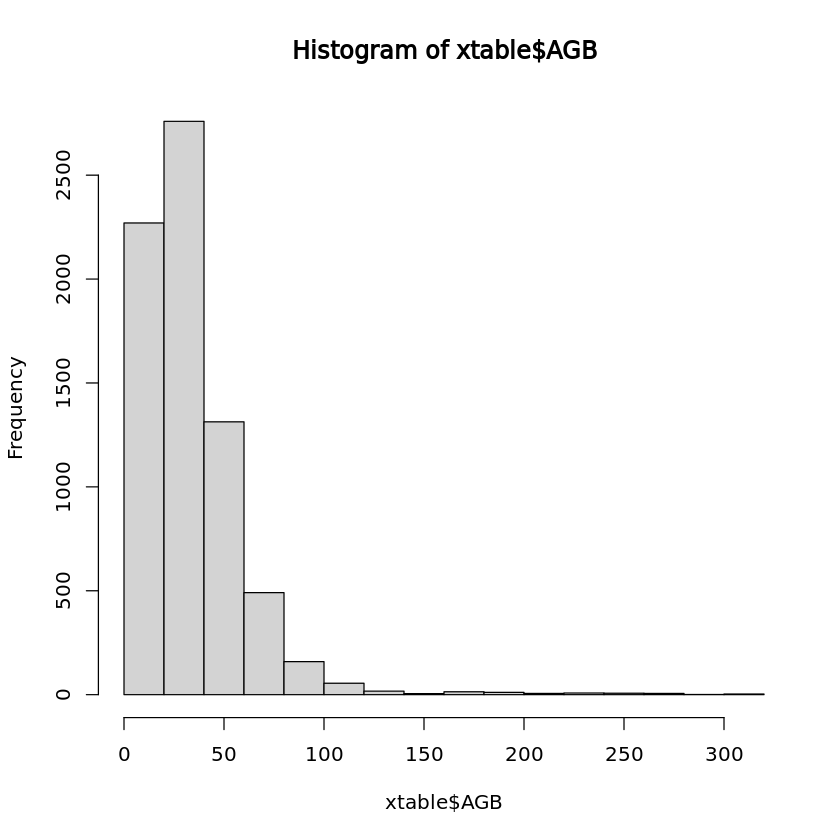

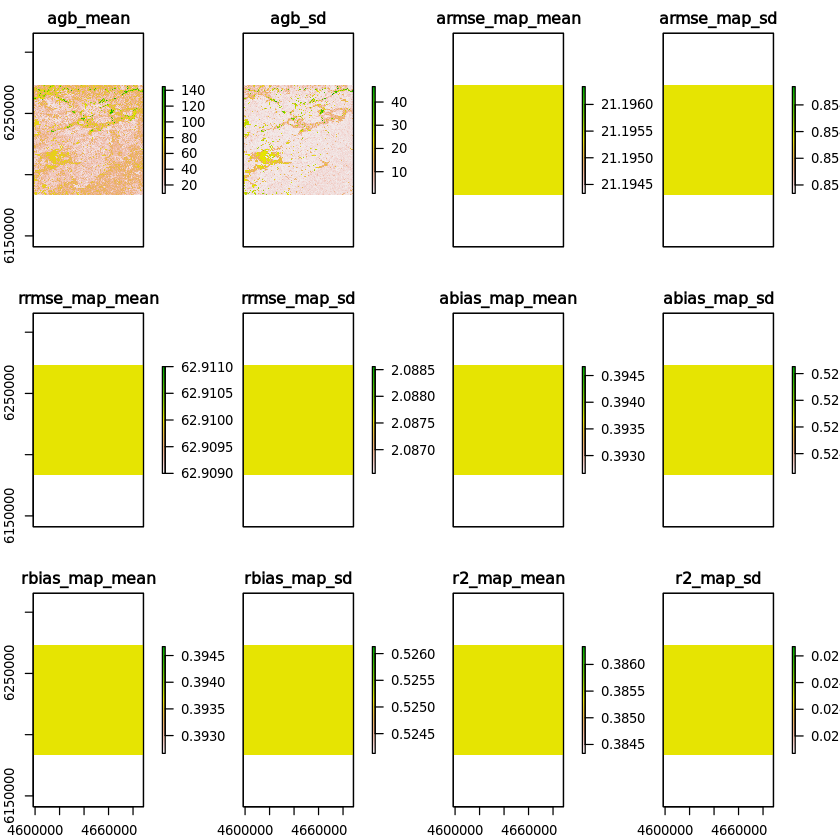

In [110]:
maps<-mapBoreal(rds_models=rds_models,
                models_id=models_id,
                ice2_30_atl08_path=ice2_30_atl08_path, 
                offset=100.0,
                s_train=70, 
                rep=30,
                stack=stack,
                strat_random=FALSE,
                output=output)
plot(maps)


In [111]:
agb_map <- maps[[1]]
se_map <- maps[[2]]

In [112]:
#convert to dataframe
agb_pts <- rasterToPoints(agb_map, spatial = TRUE)
# Then to a 'conventional' dataframe
agb_pts_df  <- data.frame(agb_pts)
str(agb_pts_df)

'data.frame':	9000000 obs. of  4 variables:
 $ agb_mean: num  29.8 23.4 23.1 32.9 29.7 ...
 $ x       : num  4598537 4598567 4598597 4598627 4598657 ...
 $ y       : num  6273289 6273289 6273289 6273289 6273289 ...
 $ optional: logi  TRUE TRUE TRUE TRUE TRUE TRUE ...


In [113]:
data <- read.csv(ice2_30_atl08_path)
#str(data)
locs <- as.data.frame(na.omit(cbind(data$Xgeo, data$Ygeo)))
names(locs) <- c('Xgeo', 'Ygeo')

zeros <- which(locs$Xgeo== 0 | is.na(locs$Xgeo)==TRUE)

if(length(zeros)>1){
    print(length(zeros))
   locs <- locs[-zeros,] 
}

min(locs$Xgeo)
min(locs$Ygeo)
names(locs) <- c('x', 'y')

[1] 7


[1] 6183319

[1] 4598537

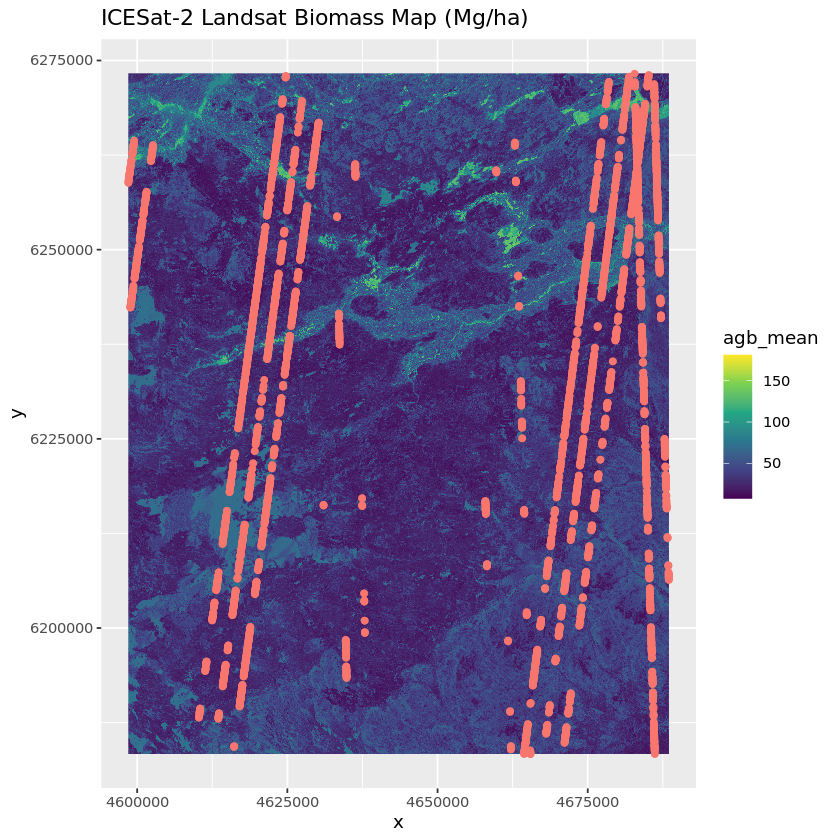

In [114]:
ggplot() +
 geom_raster(data = agb_pts_df , aes(x = x, y = y, fill = agb_mean)) + 
    scale_fill_viridis_c() +
    ggtitle("ICESat-2 Landsat Biomass Map (Mg/ha)") +
    geom_point(data=locs, aes(x=y, y=x, colour='red'), show.legend=FALSE)

In [103]:
data <- read.csv(ice2_30_atl08_path)
#str(data)
locs <- as.data.frame(na.omit(cbind(data$Xgeo, data$Ygeo)))
names(locs) <- c('Xgeo', 'Ygeo')
zeros <- which(locs$Xgeo== 0 | is.na(locs$Xgeo)==TRUE)

if(length(zeros)>1){
    print(length(zeros))
   locs <- locs[-zeros,] 
}

min(locs$Xgeo)

[1] 7


[1] 6183319

Don't know how to automatically pick scale for object of type RasterLayer. Defaulting to continuous.

ERROR while rich displaying an object: Error: Aesthetics must be valid data columns. Problematic aesthetic(s): fill = agb_map. 
Did you mistype the name of a data column or forget to add after_stat()?

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::

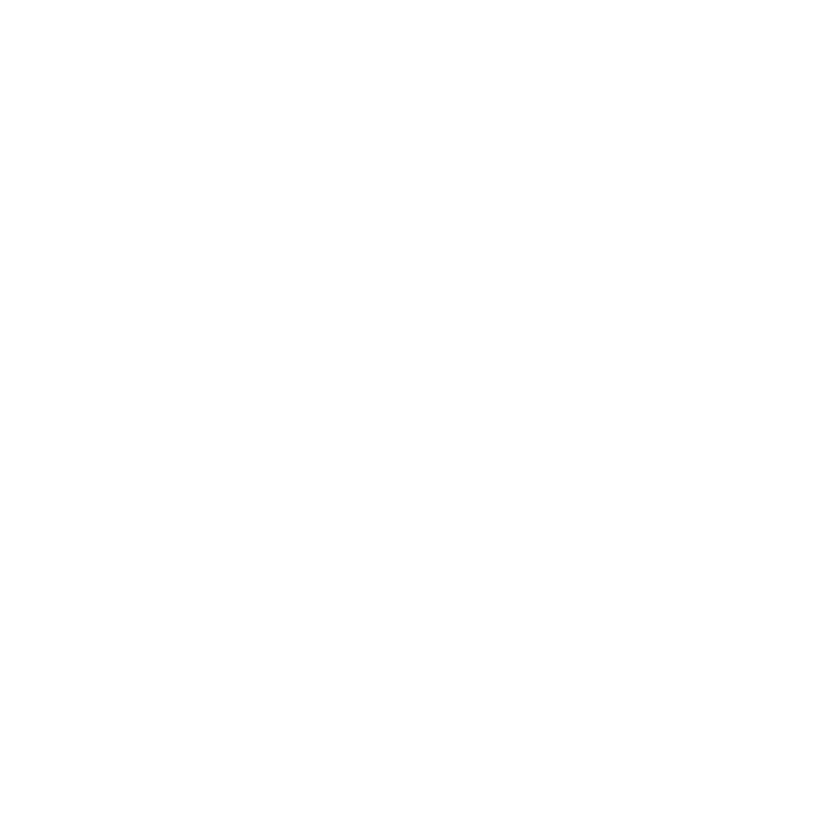

In [58]:
library(ggplot2)
ggplot() +
  geom_raster(aes(fill=agb_map))# , aes(x = x, y = y, fill = fct_elevation_2)) + 
  #coord_quickmap()
#plot(agb_map)
#plot(locs, add=TRUE, pch=19)
#plot(se_map)

In [41]:
str(locs)

 num [1:210, 1:2] 4654759 4661449 4661479 4661569 4661599 ...


In [35]:
#plot ICESat-2 locations over raster
data <- read.csv(ice2_30_atl08_path[1])
str(data)

'data.frame':	210 obs. of  36 variables:
 $ lon        : num  -100 -100 -100 -100 -100 ...
 $ lat        : num  63.4 63.4 63.4 63.4 63.4 ...
 $ rh25       : num  3.425 0.258 0.284 0.658 0.937 ...
 $ rh50       : num  3.786 0.275 0.382 1.672 1.608 ...
 $ rh60       : num  3.827 0.282 0.412 1.812 1.984 ...
 $ rh70       : num  3.929 0.289 0.433 1.892 2.082 ...
 $ rh75       : num  3.998 0.292 0.442 1.906 2.118 ...
 $ rh80       : num  4.062 0.295 0.457 1.94 2.15 ...
 $ rh90       : num  4.17 0.302 0.507 2.02 2.201 ...
 $ h_can      : num  4.437 0.307 0.587 2.091 2.28 ...
 $ h_max_can  : num  4.584 0.309 0.66 4.392 2.354 ...
 $ seg_landcov: int  10 9 9 9 9 10 10 7 7 7 ...
 $ geometry   : chr  "POINT (3067072.893080219 4663435.038330097)" "POINT (3060379.035774087 4665372.40043021)" "POINT (3060349.818518226 4665380.904692967)" "POINT (3060262.175776753 4665406.447923264)" ...
 $ elevation  : num  306 284 284 284 284 ...
 $ slope      : num  4.11 0 0 0 0 ...
 $ tsri       : num  0.969 0.5 

In [48]:
locs <- as.data.frame(cbind(data$Xgeo, data$Ygeo))
names(locs) <- c('x', 'y')
str(locs)
coordinates(locs) <- ~x+y

'data.frame':	210 obs. of  2 variables:
 $ x: num  4654759 4661449 4661479 4661569 4661599 ...
 $ y: num  3058397 3056447 3056447 3056417 3056417 ...


In [24]:
agb_map[[1]]

class      : RasterLayer 
dimensions : 3000, 3000, 9e+06  (nrow, ncol, ncell)
resolution : 30, 30  (x, y)
extent     : 4598522, 4688522, 6183304, 6273304  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : agb_mean 
values     : 3.487907, 24.66694  (min, max)


In [10]:
#----------------------------------------------#
# AGB modeling and mapping
#----------------------------------------------#
maps<-mapBoreal(rds_models=rds_models,
                models_id=models_id,
                ice2_30_atl08_path=ice2_30_atl08_path, 
                offset=100.0,
                s_train=100, 
                rep=1,
                stack=stack,
                strat_random=TRUE,
                output=output)

plot(maps)

Warning message in file(file, "rt"):
“cannot open file '/projects/shared-buckets/nathanmthomas/out_tiles/atl08_filt_topo_landsat_20210806_986.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [5]:
str(read.csv(ice2_30_atl08_path))

'data.frame':	7125 obs. of  35 variables:
 $ lon      : num  -69.7 -69.7 -69.7 -69.7 -69.7 ...
 $ lat      : num  51.3 51.3 51.3 51.3 51.7 ...
 $ rh25     : num  1.12 4.53 2.09 3.28 0.8 ...
 $ rh50     : num  1.48 6.178 4.331 5.441 0.984 ...
 $ rh60     : num  2.45 7.27 4.67 6.04 1.5 ...
 $ rh70     : num  3.25 7.96 5.2 6.92 2.02 ...
 $ rh75     : num  3.32 8.73 5.69 7.52 2.28 ...
 $ rh80     : num  3.53 8.89 6.04 7.57 2.31 ...
 $ rh90     : num  7.75 9.94 6.98 8.12 2.35 ...
 $ h_can    : num  13.58 11.32 9.14 9.88 2.39 ...
 $ h_max_can: num  14.4 11.5 10.9 10.4 2.4 ...
 $ geometry : chr  "POINT (4655531.98790389 6240788.991718134)" "POINT (4655562.074760491 6240788.097300721)" "POINT (4655622.248133902 6240786.300359203)" "POINT (4655652.33658551 6240785.451901416)" ...
 $ elevation: num  460 459 457 456 513 ...
 $ slope    : num  3.47 2.3 3.34 4.75 1.83 ...
 $ tsri     : num  0.00821 0.03955 0.55356 0.54681 0.10158 ...
 $ tpi      : num  -0.447083 0.000916 0.730438 1.031708 -0.901611

In [31]:
rds_models=rds_models
models_id=models_id
ice2_30_atl08_path=ice2_30_atl08_path 
offset=100.0
s_train=70
rep=10
stack=stack
strat_random=TRUE
output=output
# rds_models
  names(rds_models)<-models_id
  # read table
  xtable<-read.table(ice2_30_atl08_path, sep=",", head=T)
  xtable_i<-na.omit(as.data.frame(xtable))
  names(xtable_i)[1:11]<-c("lon","lat","RH_25","RH_50","RH_60","RH_70","RH_75","RH_80","RH_90","RH_95","RH_98")
  
  

In [32]:
str(xtable_i[3:11])

'data.frame':	7125 obs. of  9 variables:
 $ RH_25: num  1.12 4.53 2.09 3.28 0.8 ...
 $ RH_50: num  1.48 6.178 4.331 5.441 0.984 ...
 $ RH_60: num  2.45 7.27 4.67 6.04 1.5 ...
 $ RH_70: num  3.25 7.96 5.2 6.92 2.02 ...
 $ RH_75: num  3.32 8.73 5.69 7.52 2.28 ...
 $ RH_80: num  3.53 8.89 6.04 7.57 2.31 ...
 $ RH_90: num  7.75 9.94 6.98 8.12 2.35 ...
 $ RH_95: num  13.58 11.32 9.14 9.88 2.39 ...
 $ RH_98: num  14.4 11.5 10.9 10.4 2.4 ...


In [33]:
#
  xtable_sqrt<-sqrt(xtable_i[3:11])
  names(xtable_sqrt)<-paste0("sqrt(",names(xtable_sqrt),")")
  #xtable_sqrt<-cbind(xtable_i,xtable_sqrt)


Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”
Warning message in FUN(X[[i]], ...):
“NaNs produced”


In [34]:
  xtable_sqrt<-xtable_i
  xtable_sqrt[,3:13]<-xtable_sqrt[,3:13]+offset
  
  # get unique ids
  ids<-unique(xtable_sqrt$model_id)

  # apply models by id
  xtable_sqrt$AGB<-NA
  xtable_sqrt$SE<-NA
  

ERROR: Error in FUN(left, right): non-numeric argument to binary operator


In [35]:
#i=ids[1]
  for ( i in ids){
    
    # subset data for model id
    model_i<-readRDS(rds_models[names(rds_models)==i])
    
    # SE
    xtable_sqrt$SE[xtable_sqrt$model_id==i] <- summary(model_i)$sigma
    
    # AGB prediction
    xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-predict(model_i, newdata=xtable_sqrt[xtable_sqrt$model_id==i,])
    
    #adjust for offset in model fits (note, this was 20 for ages, and now it's 100; essentially we added to all the height metrics so they would never be negative)
    #xtable_sqrt$AGB[xtable_sqrt$model_id==i] <- xtable_sqrt$AGB[xtable_sqrt$model_id==i]+offset
    
    #define C
    C <- mean(model_i$fitted.values)/mean(model_i$model$`sqrt(AGBD)`)
    
    #we multiply by C in case there is a systematic over or under estimation in the model (bias correction)
    xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-C*xtable_sqrt$AGB[xtable_sqrt$model_id==i]^2
    #print(head(xtable_sqrt$AGB[xtable_sqrt$model_id==i]))
  }
  xtable2<-xtable_sqrt[,c(names(xtable_i),"AGB","SE")]
  colnames(xtable2)[3:12]<-colnames(xtable)[3:12]

ERROR: Error in eval(expr, envir, enclos): object 'ids' not found
